# Import Library

In [3]:
import os
os.cpu_count()

20

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import joblib

from time import time

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, classification_report

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from itertools import product

from time import time

import shap
import lime
import lime.lime_tabular
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import mutual_info_classif

# Read Data

In [5]:
file_path = "../data/Data Clean/Data Final For Modeling.csv"
df = pd.read_csv(file_path)

# Tampilkan 5 baris pertama
df.head()

,Kabupaten/Kota,Tahun,Garis Kemiskinan,Indeks Pembangunan Manusia,Jumlah Penduduk Miskin,Indeks Kedalaman Kemiskinan,Indeks Keparahan Kemiskinan,Pengeluaran Perkapita Bahan Makanan Lainnya,Pengeluaran Perkapita Bahan Minuman,Pengeluaran Perkapita Buah-Buahan,...,Rata-rata Lama Sekolah_Perempuan,NCPR,Kemiskinan (%),Pengeluaran Pangan (%),Tanpa Listrik (%),Tanpa Air Bersih (%),Rasio Tenaga Kesehatan,Angka Harapan Hidup,Stunting (%),Kelompok IKP
0,Aceh Barat,2018,447089.0,70.47,39.56,3.91,1.13,1596.38,4203.72,5558.00,...,8.83,0.42,20.28,42.10,2.29,33.76,2.32,67.62,33.20,5
1,Aceh Barat,2019,471058.0,71.22,39.29,3.53,0.97,1617.34,3978.93,7009.00,...,8.84,0.68,19.31,40.58,1.45,29.88,2.75,67.72,32.63,5
2,Aceh Barat,2020,517264.0,71.38,39.06,2.74,0.68,1906.06,3908.43,8432.00,...,9.15,0.71,18.79,20.21,0.48,20.25,2.73,67.93,0.00,6
3,Aceh Barat,2021,533712.0,71.67,39.83,3.82,1.09,2064.32,3931.38,9377.00,...,9.39,0.56,18.34,29.72,0.43,24.74,2.38,67.98,0.00,6
4,Aceh Barat,2022,558638.0,72.34,38.46,2.22,0.45,2011.67,4036.28,11058.28,...,9.58,0.56,18.81,38.49,0.00,21.76,1.82,67.99,27.40,6


In [6]:
# Lihat nama-nama kolom
df.columns.tolist()

['Kabupaten/Kota',
 'Tahun',
 'Garis Kemiskinan',
 'Indeks Pembangunan Manusia',
 'Jumlah Penduduk Miskin',
 'Indeks Kedalaman Kemiskinan',
 'Indeks Keparahan Kemiskinan',
 'Pengeluaran Perkapita Bahan Makanan Lainnya',
 'Pengeluaran Perkapita Bahan Minuman',
 'Pengeluaran Perkapita Buah-Buahan',
 'Pengeluaran Perkapita Daging',
 'Pengeluaran Perkapita Kacang-Kacangan',
 'Pengeluaran Perkapita Bahan Minyak dan Kelapa',
 'Pengeluaran Perkapita Padi-Padian',
 'Pengeluaran Perkapita Rokok dan Tembakau',
 'Pengeluaran Perkapita Telur dan Susu',
 'Pengeluaran Perkapita Umbi-Umbian',
 'Persentase Penduduk Miskin',
 'Prevalensi Konsumsi Pangan Tidak Cukup',
 'Rata-rata Lama Sekolah_Laki-laki',
 'Rata-rata Lama Sekolah_Perempuan',
 'NCPR',
 'Kemiskinan (%)',
 'Pengeluaran Pangan (%)',
 'Tanpa Listrik (%)',
 'Tanpa Air Bersih (%)',
 'Rasio Tenaga Kesehatan',
 'Angka Harapan Hidup',
 'Stunting (%)',
 'Kelompok IKP']

In [7]:
df.shape

(3598, 30)

# Feature Engineering

In [8]:
# Buat kolom baru 'is_kota'
df['is_kota'] = df['Kabupaten/Kota'].str.startswith('Kota ').astype(int)

# Cek hasilnya
df[['Kabupaten/Kota', 'is_kota']][df["is_kota"]==1]

,Kabupaten/Kota,is_kota
1204,Kota Ambon,1
1205,Kota Ambon,1
1206,Kota Ambon,1
1207,Kota Ambon,1
1208,Kota Ambon,1
...,...,...
1892,Kota Kotamobagu,1
1893,Kota Kotamobagu,1
1894,Kota Kotamobagu,1
1895,Kota Kotamobagu,1


In [9]:
# Hitung jumlah nilai unik untuk is_kota == 1
jumlah_kota_unik = df[df['is_kota'] == 1]['Kabupaten/Kota'].nunique()
jumlah_kabupaten_unik = df[df['is_kota'] == 0]['Kabupaten/Kota'].nunique()

print(f"Jumlah unik 'Kabupaten/Kota' yang merupakan kota: {jumlah_kota_unik}")
print(f"Jumlah unik 'Kabupaten/Kota' yang merupakan kabupaten: {jumlah_kabupaten_unik}")

Jumlah unik 'Kabupaten/Kota' yang merupakan kota: 98
Jumlah unik 'Kabupaten/Kota' yang merupakan kabupaten: 416


In [10]:
# Recode Kelompok IKP menjadi Target biner
df['Target'] = df['Kelompok IKP'].apply(lambda x: 0 if x in [1, 2, 3] else 1)

# Cek distribusi nilai Target
print(df['Target'].value_counts())

Target
1    3086
0     512
Name: count, dtype: int64


In [11]:
# Pisahkan Data
df_2018_2023 = df[df["Tahun"].between(2018, 2023)].reset_index(drop=True)
df_2024 = df[df["Tahun"] == 2024].reset_index(drop=True)

# Ringkasan hasil
print(f"📆 Baris 2018–2023: {len(df_2018_2023)}")
print(f"📆 Baris 2024: {len(df_2024)}")

📆 Baris 2018–2023: 3084
📆 Baris 2024: 514


In [12]:
# Drop kolom non-fitur
df_model = df_2018_2023.drop(columns=['Kabupaten/Kota', 'Tahun', 'Kelompok IKP'])

# Cek hasil
df_model.columns.tolist()

['Garis Kemiskinan',
 'Indeks Pembangunan Manusia',
 'Jumlah Penduduk Miskin',
 'Indeks Kedalaman Kemiskinan',
 'Indeks Keparahan Kemiskinan',
 'Pengeluaran Perkapita Bahan Makanan Lainnya',
 'Pengeluaran Perkapita Bahan Minuman',
 'Pengeluaran Perkapita Buah-Buahan',
 'Pengeluaran Perkapita Daging',
 'Pengeluaran Perkapita Kacang-Kacangan',
 'Pengeluaran Perkapita Bahan Minyak dan Kelapa',
 'Pengeluaran Perkapita Padi-Padian',
 'Pengeluaran Perkapita Rokok dan Tembakau',
 'Pengeluaran Perkapita Telur dan Susu',
 'Pengeluaran Perkapita Umbi-Umbian',
 'Persentase Penduduk Miskin',
 'Prevalensi Konsumsi Pangan Tidak Cukup',
 'Rata-rata Lama Sekolah_Laki-laki',
 'Rata-rata Lama Sekolah_Perempuan',
 'NCPR',
 'Kemiskinan (%)',
 'Pengeluaran Pangan (%)',
 'Tanpa Listrik (%)',
 'Tanpa Air Bersih (%)',
 'Rasio Tenaga Kesehatan',
 'Angka Harapan Hidup',
 'Stunting (%)',
 'is_kota',
 'Target']

In [13]:
df_model.head()

,Garis Kemiskinan,Indeks Pembangunan Manusia,Jumlah Penduduk Miskin,Indeks Kedalaman Kemiskinan,Indeks Keparahan Kemiskinan,Pengeluaran Perkapita Bahan Makanan Lainnya,Pengeluaran Perkapita Bahan Minuman,Pengeluaran Perkapita Buah-Buahan,Pengeluaran Perkapita Daging,Pengeluaran Perkapita Kacang-Kacangan,...,NCPR,Kemiskinan (%),Pengeluaran Pangan (%),Tanpa Listrik (%),Tanpa Air Bersih (%),Rasio Tenaga Kesehatan,Angka Harapan Hidup,Stunting (%),is_kota,Target
0,447089.0,70.47,39.56,3.91,1.13,1596.38,4203.72,5558.00,2815.84,1574.21,...,0.42,20.28,42.10,2.29,33.76,2.32,67.62,33.20,0,1
1,471058.0,71.22,39.29,3.53,0.97,1617.34,3978.93,7009.00,3115.17,1554.97,...,0.68,19.31,40.58,1.45,29.88,2.75,67.72,32.63,0,1
2,517264.0,71.38,39.06,2.74,0.68,1906.06,3908.43,8432.00,4125.04,2049.18,...,0.71,18.79,20.21,0.48,20.25,2.73,67.93,0.00,0,1
3,533712.0,71.67,39.83,3.82,1.09,2064.32,3931.38,9377.00,5878.02,2187.72,...,0.56,18.34,29.72,0.43,24.74,2.38,67.98,0.00,0,1
4,558638.0,72.34,38.46,2.22,0.45,2011.67,4036.28,11058.28,5881.19,2194.79,...,0.56,18.81,38.49,0.00,21.76,1.82,67.99,27.40,0,1


# Split Data

In [14]:
# Pisahkan fitur dan target
X = df_model.drop(columns=['Target'])
y = df_model['Target']

# Cek bentuk hasil
print("Ukuran X:", X.shape)
print("Ukuran y:", y.shape)

Ukuran X: (3084, 28)
Ukuran y: (3084,)


In [15]:
# Split data (80% latih, 20% uji) dengan stratifikasi
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Cek hasil split
print("Ukuran X_train:", X_train.shape)
print("Ukuran y_train:", y_train.shape)
print("Distribusi y_train:\n", y_train.value_counts(), "\n")
print("Distribusi y_test:\n", y_test.value_counts())

Ukuran X_train: (2467, 28)
Ukuran y_train: (2467,)
Distribusi y_train:
 Target
1    2107
0     360
Name: count, dtype: int64 

Distribusi y_test:
 Target
1    527
0     90
Name: count, dtype: int64


In [16]:
# SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Distribusi kelas setelah SMOTE:")
print(y_train_smote.value_counts())

Distribusi kelas setelah SMOTE:
Target
1    2107
0    2107
Name: count, dtype: int64


In [17]:
# ADASYN
adasyn = ADASYN(random_state=42)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)

print("Distribusi kelas setelah ADASYN:")
print(y_train_adasyn.value_counts())

Distribusi kelas setelah ADASYN:
Target
0    2115
1    2107
Name: count, dtype: int64


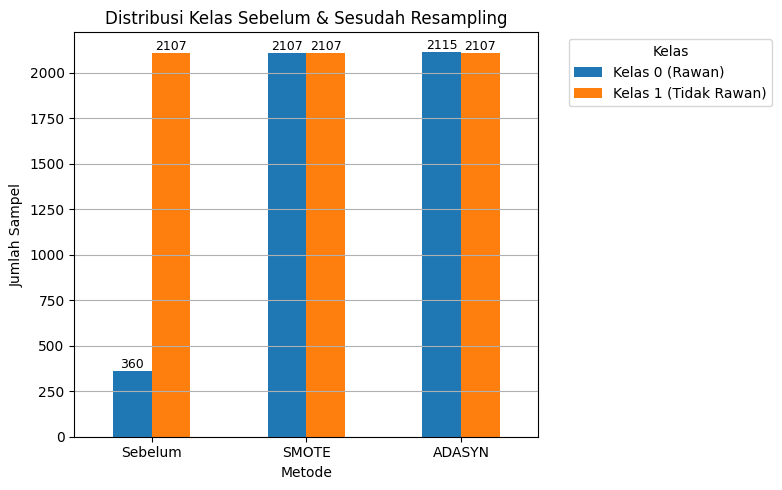

In [18]:
# Ringkasan distribusi kelas
resampling_summary = {
    'Sebelum': y_train.value_counts(),
    'SMOTE': y_train_smote.value_counts(),
    'ADASYN': y_train_adasyn.value_counts()
}

df_resample = pd.DataFrame(resampling_summary)
df_resample.index = ['Kelas 0 (Rawan)', 'Kelas 1 (Tidak Rawan)']
df_resample = df_resample.T

# Plot
ax = df_resample.plot(kind='bar', figsize=(8, 5))
plt.title('Distribusi Kelas Sebelum & Sesudah Resampling')
plt.ylabel('Jumlah Sampel')
plt.xlabel('Metode')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.legend(title='Kelas', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Tambahkan label angka di atas batang
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', xy=(p.get_x() + p.get_width() / 2, height),
                xytext=(0, 0), textcoords='offset points',
                ha='center', va='bottom', fontsize=9)

# Modeling Baseline

In [19]:
def evaluate_model(y_true, y_pred, model_name="Model"):
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred, labels=[1, 0])
    print(f"\n🔍 Evaluasi: {model_name}")
    print("Confusion Matrix:\n", cm)

    # Accuracy & Balanced Accuracy
    acc = accuracy_score(y_true, y_pred)
    bal_acc = balanced_accuracy_score(y_true, y_pred)

    # Precision, Recall, F1
    prec_pos = precision_score(y_true, y_pred, pos_label=1)
    rec_pos = recall_score(y_true, y_pred, pos_label=1)
    f1_pos = f1_score(y_true, y_pred, pos_label=1)

    prec_w = precision_score(y_true, y_pred, average='weighted')
    rec_w = recall_score(y_true, y_pred, average='weighted')
    f1_w = f1_score(y_true, y_pred, average='weighted')

    prec_m = precision_score(y_true, y_pred, average='macro')
    rec_m = recall_score(y_true, y_pred, average='macro')
    f1_m = f1_score(y_true, y_pred, average='macro')

    # Print all key metrics
    print(f"\n")
    print(f"Accuracy         : {acc:.4f}")
    print(f"Balanced Accuracy: {bal_acc:.4f}")
    print(f"Precision (Pos=1): {prec_pos:.4f} | Weighted: {prec_w:.4f} | Macro: {prec_m:.4f}")
    print(f"Recall    (Pos=1): {rec_pos:.4f} | Weighted: {rec_w:.4f} | Macro: {rec_m:.4f}")
    print(f"F1-Score  (Pos=1): {f1_pos:.4f} | Weighted: {f1_w:.4f} | Macro: {f1_m:.4f}")

    # Print all key metrics
    #print(f"\n")
    #print(f"Accuracy  : {acc:.4f}")
    #print(f"Precision : {prec_pos:.4f}")
    #print(f"Recall    : {rec_pos:.4f}")
    #print(f"F1-Score  : {f1_pos:.4f}")

    # Return dictionary
    return {
        'Model': model_name,
        'Accuracy': acc,
        'Balanced Accuracy': bal_acc,
        'Precision (pos=1)': prec_pos,
        'Recall (pos=1)': rec_pos,
        'F1 (pos=1)': f1_pos,
        'Precision (weighted)': prec_w,
        'Recall (weighted)': rec_w,
        'F1 (weighted)': f1_w,
        'Precision (macro)': prec_m,
        'Recall (macro)': rec_m,
        'F1 (macro)': f1_m,
        'Confusion Matrix': cm.tolist()
    }

## Random Forest

In [23]:
# 1. Random Forest - Tanpa Resampling
start = time()
rf_baseline_tanpa = RandomForestClassifier(random_state=42)
rf_baseline_tanpa.fit(X_train, y_train)
end = time()
print(f"\n🕒 Waktu training (Tanpa Resampling): {end - start:.2f} detik")
#joblib.dump(rf_baseline_tanpa, "../model/rf_baseline_tanpa.joblib")


🕒 Waktu training (Tanpa Resampling): 2.01 detik


In [24]:
#rf_baseline_tanpa = joblib.load("../model/rf_baseline_tanpa.joblib")
y_pred_tanpa = rf_baseline_tanpa.predict(X_test)
eval_rf_baseline_tanpa = evaluate_model(y_test, y_pred_tanpa, model_name="Random Forest - Tanpa Resampling")
eval_rf_baseline_tanpa["Training Time (s)"] = round(end - start, 2)


🔍 Evaluasi: Random Forest - Tanpa Resampling
Confusion Matrix:
 [[525   2]
 [  7  83]]


Accuracy         : 0.9854
Balanced Accuracy: 0.9592
Precision (Pos=1): 0.9868 | Weighted: 0.9853 | Macro: 0.9817
Recall    (Pos=1): 0.9962 | Weighted: 0.9854 | Macro: 0.9592
F1-Score  (Pos=1): 0.9915 | Weighted: 0.9852 | Macro: 0.9700


In [25]:
# 2. Random Forest - SMOTE
start = time()
rf_baseline_smote = RandomForestClassifier(random_state=42)
rf_baseline_smote.fit(X_train_smote, y_train_smote)
end = time()
print(f"\n🕒 Waktu training (SMOTE): {end - start:.2f} detik")
#joblib.dump(rf_baseline_smote, "../model/rf_baseline_smote.joblib")


🕒 Waktu training (SMOTE): 3.44 detik


In [26]:
#rf_baseline_smote = joblib.load("../model/rf_baseline_smote.joblib")
y_pred_smote = rf_baseline_smote.predict(X_test)
eval_rf_baseline_smote = evaluate_model(y_test, y_pred_smote, model_name="Random Forest - SMOTE")
eval_rf_baseline_smote["Training Time (s)"] = round(end - start, 2)


🔍 Evaluasi: Random Forest - SMOTE
Confusion Matrix:
 [[516  11]
 [  2  88]]


Accuracy         : 0.9789
Balanced Accuracy: 0.9785
Precision (Pos=1): 0.9961 | Weighted: 0.9805 | Macro: 0.9425
Recall    (Pos=1): 0.9791 | Weighted: 0.9789 | Macro: 0.9785
F1-Score  (Pos=1): 0.9876 | Weighted: 0.9793 | Macro: 0.9594


In [27]:
# 3. Random Forest - ADASYN
start = time()
rf_baseline_adasyn = RandomForestClassifier(random_state=42)
rf_baseline_adasyn.fit(X_train_adasyn, y_train_adasyn)
end = time()
print(f"\n🕒 Waktu training (ADASYN): {end - start:.2f} detik")
#joblib.dump(rf_baseline_adasyn, "../model/rf_baseline_adasyn.joblib")


🕒 Waktu training (ADASYN): 3.48 detik


In [28]:
#rf_baseline_adasyn = joblib.load("../model/rf_baseline_adasyn.joblib")
y_pred_adasyn = rf_baseline_adasyn.predict(X_test)
eval_rf_baseline_adasyn = evaluate_model(y_test, y_pred_adasyn, model_name="Random Forest - ADASYN")
eval_rf_baseline_adasyn["Training Time (s)"] = round(end - start, 2)


🔍 Evaluasi: Random Forest - ADASYN
Confusion Matrix:
 [[511  16]
 [  2  88]]


Accuracy         : 0.9708
Balanced Accuracy: 0.9737
Precision (Pos=1): 0.9961 | Weighted: 0.9742 | Macro: 0.9211
Recall    (Pos=1): 0.9696 | Weighted: 0.9708 | Macro: 0.9737
F1-Score  (Pos=1): 0.9827 | Weighted: 0.9717 | Macro: 0.9450


## Extreme Gradient Boosting

In [29]:
# 1. XGBoost - Tanpa Resampling
start = time()
xgb_baseline_tanpa = XGBClassifier(
    tree_method='hist',
    device='cuda',
    random_state=42,
    eval_metric='logloss'
)
xgb_baseline_tanpa.fit(X_train, y_train)
end = time()
print(f"\n🕒 Waktu training XGBoost (Tanpa Resampling): {end - start:.2f} detik")
#joblib.dump(xgb_baseline_tanpa, "../model/xgb_baseline_tanpa.joblib")


🕒 Waktu training XGBoost (Tanpa Resampling): 2.34 detik


In [30]:
#xgb_baseline_tanpa = joblib.load("../model/xgb_baseline_tanpa.joblib")
y_pred_xgb_tanpa = xgb_baseline_tanpa.predict(X_test)
eval_xgb_baseline_tanpa = evaluate_model(y_test, y_pred_xgb_tanpa, model_name="XGBoost - Tanpa Resampling")
eval_xgb_baseline_tanpa["Training Time (s)"] = round(end - start, 2)


🔍 Evaluasi: XGBoost - Tanpa Resampling
Confusion Matrix:
 [[524   3]
 [  5  85]]


Accuracy         : 0.9870
Balanced Accuracy: 0.9694
Precision (Pos=1): 0.9905 | Weighted: 0.9870 | Macro: 0.9782
Recall    (Pos=1): 0.9943 | Weighted: 0.9870 | Macro: 0.9694
F1-Score  (Pos=1): 0.9924 | Weighted: 0.9870 | Macro: 0.9737


C:\Users\uccan\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:729: UserWarning: [17:30:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


In [31]:
# 2. XGBoost - SMOTE
start = time()
xgb_baseline_smote = XGBClassifier(
    tree_method='hist',
    device='cuda',
    random_state=42,
    eval_metric='logloss'
)
xgb_baseline_smote.fit(X_train_smote, y_train_smote)
end = time()
print(f"\n🕒 Waktu training XGBoost (SMOTE): {end - start:.2f} detik")
#joblib.dump(xgb_baseline_smote, "../model/xgb_baseline_smote.joblib")


🕒 Waktu training XGBoost (SMOTE): 0.33 detik


In [81]:
xgb_baseline_smote = joblib.load("../model/xgb_baseline_smote.joblib")
y_pred_xgb_smote = xgb_baseline_smote.predict(X_test)
eval_xgb_baseline_smote = evaluate_model(y_test, y_pred_xgb_smote, model_name="XGBoost - SMOTE")
eval_xgb_baseline_smote["Training Time (s)"] = round(end - start, 2)


🔍 Evaluasi: XGBoost - SMOTE
Confusion Matrix:
 [[521   6]
 [  3  87]]


Accuracy         : 0.9854
Balanced Accuracy: 0.9776
Precision (Pos=1): 0.9943 | Weighted: 0.9857 | Macro: 0.9649
Recall    (Pos=1): 0.9886 | Weighted: 0.9854 | Macro: 0.9776
F1-Score  (Pos=1): 0.9914 | Weighted: 0.9855 | Macro: 0.9711


In [32]:
# 3. XGBoost - ADASYN
start = time()
xgb_baseline_adasyn = XGBClassifier(
    tree_method='hist',
    device='cuda',
    random_state=42,
    eval_metric='logloss'
)
xgb_baseline_adasyn.fit(X_train_adasyn, y_train_adasyn)
end = time()
print(f"\n🕒 Waktu training XGBoost (ADASYN): {end - start:.2f} detik")
#joblib.dump(xgb_baseline_adasyn, "../model/xgb_baseline_adasyn.joblib")


🕒 Waktu training XGBoost (ADASYN): 0.50 detik


In [33]:
#xgb_baseline_adasyn = joblib.load("../model/xgb_baseline_adasyn.joblib")
y_pred_xgb_adasyn = xgb_baseline_adasyn.predict(X_test)
eval_xgb_baseline_adasyn = evaluate_model(y_test, y_pred_xgb_adasyn, model_name="XGBoost - ADASYN")
eval_xgb_baseline_adasyn["Training Time (s)"] = round(end - start, 2)


🔍 Evaluasi: XGBoost - ADASYN
Confusion Matrix:
 [[519   8]
 [  2  88]]


Accuracy         : 0.9838
Balanced Accuracy: 0.9813
Precision (Pos=1): 0.9962 | Weighted: 0.9846 | Macro: 0.9564
Recall    (Pos=1): 0.9848 | Weighted: 0.9838 | Macro: 0.9813
F1-Score  (Pos=1): 0.9905 | Weighted: 0.9840 | Macro: 0.9683


## Light Gradient Boosting

In [34]:
# 1. LightGBM - Tanpa Resampling
start = time()
lgb_baseline_tanpa = LGBMClassifier(
    boosting_type='gbdt',
    device='gpu',
    tree_learner='serial',
    random_state=42,
    verbose=0
)
lgb_baseline_tanpa.fit(X_train, y_train)
end = time()
print(f"\n🕒 Waktu training LightGBM (Tanpa Resampling): {end - start:.2f} detik")
#joblib.dump(lgb_baseline_tanpa, "../model/lgb_baseline_tanpa.joblib")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines

🕒 Waktu training LightGBM (Tanpa Resampling): 4.53 detik


In [35]:
#lgb_baseline_tanpa = joblib.load("../model/lgb_baseline_tanpa.joblib")
y_pred_lgb_tanpa = lgb_baseline_tanpa.predict(X_test)
eval_lgb_baseline_tanpa = evaluate_model(y_test, y_pred_lgb_tanpa, model_name="LightGBM - Tanpa Resampling")
eval_lgb_baseline_tanpa["Training Time (s)"] = round(end - start, 2)


🔍 Evaluasi: LightGBM - Tanpa Resampling
Confusion Matrix:
 [[523   4]
 [  4  86]]


Accuracy         : 0.9870
Balanced Accuracy: 0.9740
Precision (Pos=1): 0.9924 | Weighted: 0.9870 | Macro: 0.9740
Recall    (Pos=1): 0.9924 | Weighted: 0.9870 | Macro: 0.9740
F1-Score  (Pos=1): 0.9924 | Weighted: 0.9870 | Macro: 0.9740


In [36]:
# 2. LightGBM - SMOTE
start = time()
lgb_baseline_smote = LGBMClassifier(
    boosting_type='gbdt',
    device='gpu',
    tree_learner='serial',
    random_state=42,
    verbose=0
)
lgb_baseline_smote.fit(X_train_smote, y_train_smote)
end = time()
print(f"\n🕒 Waktu training LightGBM (SMOTE): {end - start:.2f} detik")
#joblib.dump(lgb_baseline_smote, "../model/lgb_baseline_smote.joblib")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines

🕒 Waktu training LightGBM (SMOTE): 3.33 detik


In [37]:
#lgb_baseline_smote = joblib.load("../model/lgb_baseline_smote.joblib")
y_pred_lgb_smote = lgb_baseline_smote.predict(X_test)
eval_lgb_baseline_smote = evaluate_model(y_test, y_pred_lgb_smote, model_name="LightGBM - SMOTE")
eval_lgb_baseline_smote["Training Time (s)"] = round(end - start, 2)


🔍 Evaluasi: LightGBM - SMOTE
Confusion Matrix:
 [[519   8]
 [  5  85]]


Accuracy         : 0.9789
Balanced Accuracy: 0.9646
Precision (Pos=1): 0.9905 | Weighted: 0.9793 | Macro: 0.9522
Recall    (Pos=1): 0.9848 | Weighted: 0.9789 | Macro: 0.9646
F1-Score  (Pos=1): 0.9876 | Weighted: 0.9791 | Macro: 0.9583


In [38]:
# 3. LightGBM - ADASYN
start = time()
lgb_baseline_adasyn = LGBMClassifier(
    boosting_type='gbdt',
    device='gpu',
    tree_learner='serial',
    random_state=42,
    verbose=0
)
lgb_baseline_adasyn.fit(X_train_adasyn, y_train_adasyn)
end = time()
print(f"\n🕒 Waktu training LightGBM (ADASYN): {end - start:.2f} detik")
#joblib.dump(lgb_baseline_adasyn, "../model/lgb_baseline_adasyn.joblib")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines

🕒 Waktu training LightGBM (ADASYN): 3.12 detik


In [39]:
#lgb_baseline_adasyn = joblib.load("../model/lgb_baseline_adasyn.joblib")
y_pred_lgb_adasyn = lgb_baseline_adasyn.predict(X_test)
eval_lgb_baseline_adasyn = evaluate_model(y_test, y_pred_lgb_adasyn, model_name="LightGBM - ADASYN")
eval_lgb_baseline_adasyn["Training Time (s)"] = round(end - start, 2)


🔍 Evaluasi: LightGBM - ADASYN
Confusion Matrix:
 [[524   3]
 [  4  86]]


Accuracy         : 0.9887
Balanced Accuracy: 0.9749
Precision (Pos=1): 0.9924 | Weighted: 0.9886 | Macro: 0.9794
Recall    (Pos=1): 0.9943 | Weighted: 0.9887 | Macro: 0.9749
F1-Score  (Pos=1): 0.9934 | Weighted: 0.9886 | Macro: 0.9771


## Neural Network

In [40]:
# 1. Neural Network - Tanpa Resampling

# Scaling Data
scaler_nn_tanpa = StandardScaler()
X_train_scaled = scaler_nn_tanpa.fit_transform(X_train)
X_test_scaled = scaler_nn_tanpa.transform(X_test)

In [43]:
# Modeling
model_nn_baseline_tanpa = Sequential()
model_nn_baseline_tanpa.add(Input(shape=(X_train_scaled.shape[1],)))
model_nn_baseline_tanpa.add(Dense(128, activation='relu'))
model_nn_baseline_tanpa.add(Dropout(0.5))
model_nn_baseline_tanpa.add(Dense(64, activation='relu'))
model_nn_baseline_tanpa.add(Dropout(0.3))
model_nn_baseline_tanpa.add(Dense(32, activation='relu'))
model_nn_baseline_tanpa.add(Dropout(0.2))
model_nn_baseline_tanpa.add(Dense(1, activation='sigmoid'))

model_nn_baseline_tanpa.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [44]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

start = time()
history_nn_baseline_tanpa = model_nn_baseline_tanpa.fit(
    X_train_scaled,
    y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)
end = time()
print(f"\n🕒 Waktu training NN (Tanpa Resampling): {end - start:.2f} detik")

# Simpan model ke .keras
# model_nn_baseline_tanpa.save("../model/nn_baseline_tanpa.keras")

Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.8047 - loss: 0.4885 - val_accuracy: 0.9413 - val_loss: 0.1817
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9097 - loss: 0.2523 - val_accuracy: 0.9413 - val_loss: 0.1496
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9013 - loss: 0.2706 - val_accuracy: 0.9433 - val_loss: 0.1336
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9075 - loss: 0.2388 - val_accuracy: 0.9474 - val_loss: 0.1248
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9141 - loss: 0.2143 - val_accuracy: 0.9494 - val_loss: 0.1150
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9193 - loss: 0.2201 - val_accuracy: 0.9575 - val_loss: 0.1094
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9272 - loss: 0.1870 - val_accuracy: 0.9575 - val_loss: 0.1009
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9323 - loss: 0.1791 - val_accuracy: 0.9575 - val_loss

In [46]:
# Prediksi & evaluasi
#model_nn_baseline_tanpa = load_model("../model/nn_baseline_tanpa.keras")
y_pred_prob_tanpa = model_nn_baseline_tanpa.predict(X_test_scaled)
y_pred_nn_tanpa = (y_pred_prob_tanpa >= 0.5).astype(int).flatten()

eval_nn_baseline_tanpa = evaluate_model(y_test, y_pred_nn_tanpa, model_name="NN (Baseline) - Tanpa Resampling")
eval_nn_baseline_tanpa["Training Time (s)"] = round(end - start, 2)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

🔍 Evaluasi: NN (Baseline) - Tanpa Resampling
Confusion Matrix:
 [[521   6]
 [  4  86]]


Accuracy         : 0.9838
Balanced Accuracy: 0.9721
Precision (Pos=1): 0.9924 | Weighted: 0.9840 | Macro: 0.9636
Recall    (Pos=1): 0.9886 | Weighted: 0.9838 | Macro: 0.9721
F1-Score  (Pos=1): 0.9905 | Weighted: 0.9839 | Macro: 0.9678


In [47]:
# Neural Network - SMOTE

# Scaling Data
scaler_nn_smote = StandardScaler()
X_train_smote_scaled = scaler_nn_smote.fit_transform(X_train_smote)
X_test_scaled = scaler_nn_smote.transform(X_test)

In [48]:
# Modeling
model_nn_baseline_smote = Sequential()
model_nn_baseline_smote.add(Input(shape=(X_train_smote_scaled.shape[1],)))
model_nn_baseline_smote.add(Dense(64, activation='relu'))
model_nn_baseline_smote.add(Dropout(0.5))
model_nn_baseline_smote.add(Dense(32, activation='relu'))
model_nn_baseline_smote.add(Dropout(0.3))
model_nn_baseline_smote.add(Dense(1, activation='sigmoid'))

model_nn_baseline_smote.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [49]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

start = time()
history_nn_baseline_smote = model_nn_baseline_smote.fit(
    X_train_smote_scaled,
    y_train_smote,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)
end = time()
print(f"\n🕒 Waktu training NN (SMOTE): {end - start:.2f} detik")

# Simpan model ke .keras
model_nn_baseline_smote.save("../model/nn_baseline_smote.keras")

Epoch 1/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6434 - loss: 0.6215 - val_accuracy: 0.7165 - val_loss: 0.4970
Epoch 2/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8368 - loss: 0.3908 - val_accuracy: 0.7794 - val_loss: 0.3823
Epoch 3/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8513 - loss: 0.3407 - val_accuracy: 0.8209 - val_loss: 0.3225
Epoch 4/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8764 - loss: 0.2927 - val_accuracy: 0.8470 - val_loss: 0.2892
Epoch 5/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8716 - loss: 0.2755 - val_accuracy: 0.8754 - val_loss: 0.2603
Epoch 6/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8978 - loss: 0.2376 - val_accuracy: 0.9027 - val_loss: 0.2208
Epoch 7/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9039 - loss: 0.2285 - val_accuracy: 0.8980 - val_loss: 0.2438
Epoch 8/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9073 - loss: 0.2134 - val_accuracy: 0.

In [50]:
# Prediksi & evaluasi
#model_nn_baseline_smote = load_model("../model/nn_baseline_smote.keras")
y_pred_prob_smote = model_nn_baseline_smote.predict(X_test_scaled)
y_pred_nn_smote = (y_pred_prob_smote >= 0.5).astype(int).flatten()

eval_nn_baseline_smote = evaluate_model(y_test, y_pred_nn_smote, model_name="NN (Baseline) - SMOTE")
eval_nn_baseline_smote["Training Time (s)"] = round(end - start, 2)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

🔍 Evaluasi: NN (Baseline) - SMOTE
Confusion Matrix:
 [[509  18]
 [  1  89]]


Accuracy         : 0.9692
Balanced Accuracy: 0.9774
Precision (Pos=1): 0.9980 | Weighted: 0.9738 | Macro: 0.9149
Recall    (Pos=1): 0.9658 | Weighted: 0.9692 | Macro: 0.9774
F1-Score  (Pos=1): 0.9817 | Weighted: 0.9703 | Macro: 0.9426


In [51]:
# Neural Network - ADASYN

# Scaling Data
scaler_nn_adasyn = StandardScaler()
X_train_adasyn_scaled = scaler_nn_adasyn.fit_transform(X_train_adasyn)
X_test_scaled = scaler_nn_adasyn.transform(X_test)

In [52]:
# Modeling
model_nn_baseline_adasyn = Sequential()
model_nn_baseline_adasyn.add(Input(shape=(X_train_adasyn_scaled.shape[1],)))
model_nn_baseline_adasyn.add(Dense(64, activation='relu'))
model_nn_baseline_adasyn.add(Dropout(0.5))
model_nn_baseline_adasyn.add(Dense(32, activation='relu'))
model_nn_baseline_adasyn.add(Dropout(0.3))
model_nn_baseline_adasyn.add(Dense(1, activation='sigmoid'))

model_nn_baseline_adasyn.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [53]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

start = time()
history_nn_baseline_adasyn = model_nn_baseline_adasyn.fit(
    X_train_adasyn_scaled,
    y_train_adasyn,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)
end = time()
print(f"\n🕒 Waktu training NN (ADASYN): {end - start:.2f} detik")

# Simpan model ke .keras
#model_nn_baseline_adasyn.save("../model/nn_baseline_adasyn.keras")

Epoch 1/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6791 - loss: 0.5879 - val_accuracy: 0.6509 - val_loss: 0.5749
Epoch 2/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8194 - loss: 0.3964 - val_accuracy: 0.7444 - val_loss: 0.4931
Epoch 3/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8345 - loss: 0.3502 - val_accuracy: 0.7373 - val_loss: 0.4787
Epoch 4/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8577 - loss: 0.3284 - val_accuracy: 0.7680 - val_loss: 0.4209
Epoch 5/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8803 - loss: 0.2905 - val_accuracy: 0.7882 - val_loss: 0.3931
Epoch 6/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8874 - loss: 0.2655 - val_accuracy: 0.8331 - val_loss: 0.3227
Epoch 7/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8990 - loss: 0.2390 - val_accuracy: 0.8414 - val_loss: 0.3175
Epoch 8/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9080 - loss: 0.2229 - val_accuracy: 0.

In [54]:
# Prediksi & evaluasi
#model_nn_baseline_adasyn = load_model("../model/nn_baseline_adasyn.keras")
y_pred_prob_adasyn = model_nn_baseline_adasyn.predict(X_test_scaled)
y_pred_nn_adasyn = (y_pred_prob_adasyn >= 0.5).astype(int).flatten()

eval_nn_baseline_adasyn = evaluate_model(y_test, y_pred_nn_adasyn, model_name="NN (Baseline) - ADASYN")
eval_nn_baseline_adasyn["Training Time (s)"] = round(end - start, 2)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

🔍 Evaluasi: NN (Baseline) - ADASYN
Confusion Matrix:
 [[518   9]
 [  5  85]]


Accuracy         : 0.9773
Balanced Accuracy: 0.9637
Precision (Pos=1): 0.9904 | Weighted: 0.9779 | Macro: 0.9473
Recall    (Pos=1): 0.9829 | Weighted: 0.9773 | Macro: 0.9637
F1-Score  (Pos=1): 0.9867 | Weighted: 0.9775 | Macro: 0.9553


# Modeling Grid Search

## Random Forest

In [55]:
# Random Forest – Tanpa Resampling

# Parameter grid
param_grid_rf_tanpa = {
    'n_estimators': [50, 100, 200, 300, 400, 500],
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Model dasar
rf_grid_tanpa = RandomForestClassifier(random_state=42)

# Grid Search
grid_search_rf_tanpa = GridSearchCV(
    estimator=rf_grid_tanpa,
    param_grid=param_grid_rf_tanpa,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=2
)

In [18]:
# Tuning
start = time()
grid_search_rf_tanpa.fit(X_train, y_train)
end = time()
grid_time = end - start
print(f"\n🕒 Waktu tuning (Tanpa Resampling): {grid_time:.2f} detik")
print("Best Params:", grid_search_rf_tanpa.best_params_)
print(f"Best Macro F1 (CV): {grid_search_rf_tanpa.best_score_:.4f}")
joblib.dump(grid_search_rf_tanpa, "../grid/grid_search_rf_tanpa.joblib")

Fitting 5 folds for each of 216 candidates, totalling 1080 fits

🕒 Waktu tuning (Tanpa Resampling): 901.17 detik
Best Params: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Macro F1 (CV): 0.9522


['Grid/grid_search_rf_tanpa.joblib']

In [56]:
# Model terbaik dan evaluasi
grid_search_rf_tanpa = joblib.load("../grid/grid_search_rf_tanpa.joblib")
start = time()
best_rf_grid_tanpa = RandomForestClassifier(**grid_search_rf_tanpa.best_params_, random_state=42)
best_rf_grid_tanpa.fit(X_train, y_train)
end = time()
print(f"\n🕒 Waktu training Random Forest (Tanpa Resampling): {end - start:.2f} detik")
#joblib.dump(best_rf_grid_tanpa, "../model/best_rf_grid_tanpa.joblib")


🕒 Waktu training Random Forest (Tanpa Resampling): 4.09 detik


['../model/best_rf_grid_tanpa.joblib']

In [57]:
#best_rf_grid_tanpa = joblib.load("../model/best_rf_grid_tanpa.joblib")
y_pred_best_grid_tanpa = best_rf_grid_tanpa.predict(X_test)
eval_rf_best_grid_tanpa = evaluate_model(y_test, y_pred_best_grid_tanpa, model_name="RF (Grid) - Tanpa Resampling")
eval_rf_best_grid_tanpa["Training Time (s)"] = round(end - start, 2)


🔍 Evaluasi: RF (Grid) - Tanpa Resampling
Confusion Matrix:
 [[525   2]
 [  7  83]]


Accuracy         : 0.9854
Balanced Accuracy: 0.9592
Precision (Pos=1): 0.9868 | Weighted: 0.9853 | Macro: 0.9817
Recall    (Pos=1): 0.9962 | Weighted: 0.9854 | Macro: 0.9592
F1-Score  (Pos=1): 0.9915 | Weighted: 0.9852 | Macro: 0.9700


In [20]:
# Random Forest – SMOTE

# Parameter grid
param_grid_rf_smote = {
    'n_estimators': [50, 100, 200, 300, 400, 500],
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Model dasar
rf_grid_smote = RandomForestClassifier(random_state=42)

# Grid Search
grid_search_rf_smote = GridSearchCV(
    estimator=rf_grid_smote,
    param_grid=param_grid_rf_smote,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=2
)

In [21]:
# Tuning
start = time()
grid_search_rf_smote.fit(X_train_smote, y_train_smote)
end = time()
grid_time = end - start
print(f"\n🕒 Waktu tuning (SMOTE): {grid_time:.2f} detik")
print("Best Params:", grid_search_rf_smote.best_params_)
print(f"Best Macro F1 (CV): {grid_search_rf_smote.best_score_:.4f}")
joblib.dump(grid_search_rf_smote, "../grid/grid_search_rf_smote.joblib")

Fitting 5 folds for each of 216 candidates, totalling 1080 fits

🕒 Waktu tuning (SMOTE): 920.33 detik
Best Params: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best Macro F1 (CV): 0.9832


['Grid/grid_search_rf_smote.joblib']

In [58]:
# Model terbaik dan evaluasi
grid_search_rf_smote = joblib.load("../grid/grid_search_rf_smote.joblib")
start = time()
best_rf_grid_smote = RandomForestClassifier(**grid_search_rf_smote.best_params_, random_state=42)
best_rf_grid_smote.fit(X_train_smote, y_train_smote)
end = time()
print(f"\n🕒 Waktu training Random Forest (SMOTE): {end - start:.2f} detik")
#joblib.dump(best_rf_grid_smote, "../model/best_rf_grid_smote.joblib")


🕒 Waktu training Random Forest (SMOTE): 10.59 detik


In [59]:
#best_rf_grid_smote = joblib.load("../model/best_rf_grid_smote.joblib")
y_pred_best_grid_smote = best_rf_grid_smote.predict(X_test)
eval_rf_best_grid_smote = evaluate_model(y_test, y_pred_best_grid_smote, model_name="RF (Grid) - SMOTE")
eval_rf_best_grid_smote["Training Time (s)"] = round(end - start, 2)


🔍 Evaluasi: RF (Grid) - SMOTE
Confusion Matrix:
 [[516  11]
 [  2  88]]


Accuracy         : 0.9789
Balanced Accuracy: 0.9785
Precision (Pos=1): 0.9961 | Weighted: 0.9805 | Macro: 0.9425
Recall    (Pos=1): 0.9791 | Weighted: 0.9789 | Macro: 0.9785
F1-Score  (Pos=1): 0.9876 | Weighted: 0.9793 | Macro: 0.9594


In [24]:
# Random Forest – ADASYN

# Parameter grid
param_grid_rf_adasyn = {
    'n_estimators': [50, 100, 200, 300, 400, 500],
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Model dasar
rf_grid_adasyn = RandomForestClassifier(random_state=42)

# Grid Search
grid_search_rf_adasyn = GridSearchCV(
    estimator=rf_grid_adasyn,
    param_grid=param_grid_rf_adasyn,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=2
)

In [25]:
# Tuning
start = time()
grid_search_rf_adasyn.fit(X_train_adasyn, y_train_adasyn)
end = time()
grid_time = end - start
print(f"\n🕒 Waktu tuning (ADASYN): {grid_time:.2f} detik")
print("Best Params:", grid_search_rf_adasyn.best_params_)
print(f"Best Macro F1 (CV): {grid_search_rf_adasyn.best_score_:.4f}")
joblib.dump(grid_search_rf_adasyn, "../grid/grid_search_rf_adasyn.joblib")

Fitting 5 folds for each of 216 candidates, totalling 1080 fits

🕒 Waktu tuning (ADASYN): 917.91 detik
Best Params: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Macro F1 (CV): 0.9803


['Grid/grid_search_rf_adasyn.joblib']

In [60]:
# Model terbaik dan evaluasi
grid_search_rf_adasyn = joblib.load("../grid/grid_search_rf_adasyn.joblib")
start = time()
best_rf_grid_adasyn = RandomForestClassifier(**grid_search_rf_adasyn.best_params_, random_state=42)
best_rf_grid_adasyn.fit(X_train_adasyn, y_train_adasyn)
end = time()
print(f"\n🕒 Waktu training Random Forest (ADASYN): {end - start:.2f} detik")
#joblib.dump(best_rf_grid_adasyn, "../model/best_rf_grid_adasyn.joblib")


🕒 Waktu training Random Forest (ADASYN): 7.41 detik


In [61]:
#best_rf_grid_adasyn = joblib.load("model/best_rf_grid_adasyn.joblib")
y_pred_best_grid_adasyn = best_rf_grid_adasyn.predict(X_test)
eval_rf_best_grid_adasyn = evaluate_model(y_test, y_pred_best_grid_adasyn, model_name="RF (Grid) - ADASYN")
eval_rf_best_grid_adasyn["Training Time (s)"] = round(end - start, 2)


🔍 Evaluasi: RF (Grid) - ADASYN
Confusion Matrix:
 [[512  15]
 [  1  89]]


Accuracy         : 0.9741
Balanced Accuracy: 0.9802
Precision (Pos=1): 0.9981 | Weighted: 0.9773 | Macro: 0.9269
Recall    (Pos=1): 0.9715 | Weighted: 0.9741 | Macro: 0.9802
F1-Score  (Pos=1): 0.9846 | Weighted: 0.9748 | Macro: 0.9511


## Extreme Gradient Boosting

In [17]:
# Extreme Gradient Boosting – Tanpa Resampling

# Parameter grid
param_grid_xgb_tanpa = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 6, 9, 12],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.3],
    'subsample': [0.7, 0.8, 1.0]
}

#param_grid_xgb_tanpa = {
#    'n_estimators': [100, 200],
#    'max_depth': [3, 6],
#    'learning_rate': [0.01, 0.05],
#    'subsample': [0.7, 0.8]
#}

# Model dasar
xgb_grid_tanpa = XGBClassifier(
    tree_method='hist',
    device='cuda',          # gunakan GPU
    eval_metric='logloss',
    random_state=42,
    verbosity=0
)

# Grid Search
grid_search_xgb_tanpa = GridSearchCV(
    estimator=xgb_grid_tanpa,
    param_grid=param_grid_xgb_tanpa,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=2
)

In [18]:
# Tuning
start = time()
grid_search_xgb_tanpa.fit(X_train, y_train)
end = time()
grid_time = end - start
print(f"\n🕒 Waktu tuning XGBoost (Tanpa Resampling): {grid_time:.2f} detik")
print("Best Params:", grid_search_xgb_tanpa.best_params_)
print(f"Best Macro F1 (CV): {grid_search_xgb_tanpa.best_score_:.4f}")
joblib.dump(grid_search_xgb_tanpa, "grid/grid_search_xgb_tanpa.joblib")

Fitting 5 folds for each of 360 candidates, totalling 1800 fits

🕒 Waktu tuning XGBoost (Tanpa Resampling): 1090.01 detik
Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.7}
Best Macro F1 (CV): 0.9650


['grid/grid_search_xgb_tanpa.joblib']

In [64]:
# Model terbaik
grid_search_xgb_tanpa = joblib.load("../grid/grid_search_xgb_tanpa.joblib")
start = time()
best_xgb_grid_tanpa = XGBClassifier(
    **grid_search_xgb_tanpa.best_params_,
    tree_method='hist',
    device='cuda',          # gunakan GPU
    eval_metric='logloss',
    random_state=42,
    verbosity=0
)
best_xgb_grid_tanpa.fit(X_train, y_train)
end = time()
print(f"\n🕒 Waktu training XGBoost terbaik (Tanpa Resampling): {end - start:.2f} detik")
#joblib.dump(best_xgb_grid_tanpa, "../model/best_xgb_grid_tanpa.joblib")


🕒 Waktu training XGBoost terbaik (Tanpa Resampling): 0.76 detik


In [66]:
# Prediksi & evaluasi
#best_xgb_grid_tanpa = joblib.load("../model/best_xgb_grid_tanpa.joblib")
y_pred_best_xgb_grid_tanpa = best_xgb_grid_tanpa.predict(X_test)
eval_xgb_best_grid_tanpa = evaluate_model(
    y_test, y_pred_best_xgb_grid_tanpa,
    model_name="XGBoost (Grid) - Tanpa Resampling"
)
eval_xgb_best_grid_tanpa["Training Time (s)"] = round(end - start, 2)


🔍 Evaluasi: XGBoost (Grid) - Tanpa Resampling
Confusion Matrix:
 [[523   4]
 [  6  84]]


Accuracy         : 0.9838
Balanced Accuracy: 0.9629
Precision (Pos=1): 0.9887 | Weighted: 0.9837 | Macro: 0.9716
Recall    (Pos=1): 0.9924 | Weighted: 0.9838 | Macro: 0.9629
F1-Score  (Pos=1): 0.9905 | Weighted: 0.9837 | Macro: 0.9672


In [18]:
# Extreme Gradient Boosting - SMOTE

# Parameter grid
param_grid_xgb_smote =  {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 6, 9, 12],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.3],
    'subsample': [0.7, 0.8, 1.0]
}

# Model dasar
xgb_grid_smote = XGBClassifier(
    tree_method='hist',
    device='cuda',
    eval_metric='logloss',
    random_state=42,
    verbosity=0
)

# Grid Search
grid_search_xgb_smote = GridSearchCV(
    estimator=xgb_grid_smote,
    param_grid=param_grid_xgb_smote,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=2
)

In [19]:
# Tuning
start = time()
grid_search_xgb_smote.fit(X_train_smote, y_train_smote)
end = time()
grid_time = end - start
print(f"\n🕒 Waktu tuning XGBoost (SMOTE): {grid_time:.2f} detik")
print("Best Params:", grid_search_xgb_smote.best_params_)
print(f"Best Macro F1 (CV): {grid_search_xgb_smote.best_score_:.4f}")
joblib.dump(grid_search_xgb_smote, "../grid/grid_search_xgb_smote.joblib")

Fitting 5 folds for each of 360 candidates, totalling 1800 fits

🕒 Waktu tuning XGBoost (SMOTE): 1136.01 detik
Best Params: {'learning_rate': 0.15, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.7}
Best Macro F1 (CV): 0.9896


['grid/grid_search_xgb_smote.joblib']

In [68]:
# Model terbaik & evaluasi
grid_search_xgb_smote = joblib.load("../grid/grid_search_xgb_smote.joblib")
start = time()
best_xgb_grid_smote = XGBClassifier(
    **grid_search_xgb_smote.best_params_,
    tree_method='hist',
    device='cuda',          # gunakan GPU
    eval_metric='logloss',
    random_state=42,
    verbosity=0
)
best_xgb_grid_smote.fit(X_train_smote, y_train_smote)
end = time()
print(f"\n🕒 Waktu training XGBoost terbaik (SMOTE): {end - start:.2f} detik")
#joblib.dump(best_xgb_grid_smote, "../model/best_xgb_grid_smote.joblib")


🕒 Waktu training XGBoost terbaik (SMOTE): 1.66 detik


In [70]:
y_pred_best_xgb_grid_smote = best_xgb_grid_smote.predict(X_test)
eval_xgb_best_grid_smote = evaluate_model(y_test, y_pred_best_xgb_grid_smote, model_name="XGBoost (Grid) - SMOTE")
eval_xgb_best_grid_smote["Training Time (s)"] = round(end - start, 2)


🔍 Evaluasi: XGBoost (Grid) - SMOTE
Confusion Matrix:
 [[520   7]
 [  3  87]]


Accuracy         : 0.9838
Balanced Accuracy: 0.9767
Precision (Pos=1): 0.9943 | Weighted: 0.9842 | Macro: 0.9599
Recall    (Pos=1): 0.9867 | Weighted: 0.9838 | Macro: 0.9767
F1-Score  (Pos=1): 0.9905 | Weighted: 0.9839 | Macro: 0.9681


In [22]:
# Extreme Gradient Boosting - ADASYN

# Parameter grid
param_grid_xgb_adasyn =  {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 6, 9, 12],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.3],
    'subsample': [0.7, 0.8, 1.0]
}

# Model dasar
xgb_grid_adasyn = XGBClassifier(
    tree_method='hist',
    device='cuda',
    eval_metric='logloss',
    random_state=42,
    verbosity=0
)

# Grid Search
grid_search_xgb_adasyn = GridSearchCV(
    estimator=xgb_grid_adasyn,
    param_grid=param_grid_xgb_adasyn,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=2
)

In [23]:
# Tuning
start = time()
grid_search_xgb_adasyn.fit(X_train_adasyn, y_train_adasyn)
end = time()
grid_time = end - start
print(f"\n🕒 Waktu tuning XGBoost (ADASYN): {grid_time:.2f} detik")
print("Best Params:", grid_search_xgb_adasyn.best_params_)
print(f"Best Macro F1 (CV): {grid_search_xgb_adasyn.best_score_:.4f}")
joblib.dump(grid_search_xgb_adasyn, "../grid/grid_search_xgb_adasyn.joblib")

Fitting 5 folds for each of 360 candidates, totalling 1800 fits

🕒 Waktu tuning XGBoost (ADASYN): 1146.75 detik
Best Params: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}
Best Macro F1 (CV): 0.9877


['grid/grid_search_xgb_adasyn.joblib']

In [71]:
grid_search_xgb_adasyn = joblib.load("../grid/grid_search_xgb_adasyn.joblib")
start = time()
best_xgb_grid_adasyn = XGBClassifier(
    **grid_search_xgb_adasyn.best_params_,
    tree_method='hist',
    device='cuda',          # gunakan GPU
    eval_metric='logloss',
    random_state=42,
    verbosity=0
)
best_xgb_grid_adasyn.fit(X_train_adasyn, y_train_adasyn)
end = time()
print(f"\n🕒 Waktu training XGBoost terbaik (ADASYN): {end - start:.2f} detik")
#joblib.dump(best_xgb_grid_adasyn, "../model/best_xgb_grid_adasyn.joblib")


🕒 Waktu training XGBoost terbaik (ADASYN): 1.15 detik


In [72]:
y_pred_best_xgb_grid_adasyn = best_xgb_grid_adasyn.predict(X_test)
eval_xgb_best_grid_adasyn = evaluate_model(y_test, y_pred_best_xgb_grid_adasyn, model_name="XGBoost (Grid) - ADASYN")
eval_xgb_best_grid_adasyn["Training Time (s)"] = round(end - start, 2)


🔍 Evaluasi: XGBoost (Grid) - ADASYN
Confusion Matrix:
 [[521   6]
 [  2  88]]


Accuracy         : 0.9870
Balanced Accuracy: 0.9832
Precision (Pos=1): 0.9962 | Weighted: 0.9874 | Macro: 0.9662
Recall    (Pos=1): 0.9886 | Weighted: 0.9870 | Macro: 0.9832
F1-Score  (Pos=1): 0.9924 | Weighted: 0.9872 | Macro: 0.9745


## Light Gradient Boosting

In [26]:
# LGB - Tanpa Resampling

# Grid
param_grid_lgb_tanpa = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 6, 9, 12],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0]
}

#param_grid_lgb_tanpa = {
#    'n_estimators': [100, 200],
#    'max_depth': [3, 6],
#    'learning_rate': [0.01, 0.05],
#    'subsample': [0.7, 0.8]
#}

# Model dasar
lgb_grid_tanpa = LGBMClassifier(
    device='gpu',
    tree_learner='serial',
    boosting_type='gbdt',
    random_state=42,
    verbose=-1
)

# Grid Search
grid_search_lgb_tanpa = GridSearchCV(
    estimator=lgb_grid_tanpa,
    param_grid=param_grid_lgb_tanpa,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=2
)

In [27]:
# Tuning
start = time()
grid_search_lgb_tanpa.fit(X_train, y_train)
end = time()
grid_time = end - start
print(f"\n🕒 Waktu tuning LightGBM (Tanpa Resampling): {grid_time:.2f} detik")
print("Best Params:", grid_search_lgb_tanpa.best_params_)
print(f"Best Macro F1 (CV): {grid_search_lgb_tanpa.best_score_:.4f}")
joblib.dump(grid_search_lgb_tanpa, "../grid/grid_search_lgb_tanpa.joblib")

Fitting 5 folds for each of 240 candidates, totalling 1200 fits

🕒 Waktu tuning LightGBM (Tanpa Resampling): 2007.10 detik
Best Params: {'learning_rate': 0.2, 'max_depth': 12, 'n_estimators': 100, 'subsample': 0.7}
Best Macro F1 (CV): 0.9652


['grid/grid_search_lgb_tanpa.joblib']

In [73]:
# Model terbaik & evaluasi
grid_search_lgb_tanpa = joblib.load("../grid/grid_search_lgb_tanpa.joblib")
start = time()
best_lgb_grid_tanpa = LGBMClassifier(
    **grid_search_lgb_tanpa.best_params_,
    device='gpu',
    tree_learner='serial',
    boosting_type='gbdt',
    random_state=42,
    verbose=-1
)
best_lgb_grid_tanpa.fit(X_train, y_train)
end = time()
print(f"\n🕒 Waktu training LightGBM terbaik (Tanpa Resampling): {end - start:.2f} detik")
#joblib.dump(best_lgb_grid_tanpa, "../model/best_lgb_grid_tanpa.joblib")


🕒 Waktu training LightGBM terbaik (Tanpa Resampling): 2.81 detik


In [74]:
y_pred_best_lgb_grid_tanpa = best_lgb_grid_tanpa.predict(X_test)
eval_lgb_best_grid_tanpa = evaluate_model(y_test, y_pred_best_lgb_grid_tanpa, model_name="LightGBM (Grid) - Tanpa Resampling")
eval_lgb_best_grid_tanpa["Training Time (s)"] = round(end - start, 2)


🔍 Evaluasi: LightGBM (Grid) - Tanpa Resampling
Confusion Matrix:
 [[524   3]
 [  6  84]]


Accuracy         : 0.9854
Balanced Accuracy: 0.9638
Precision (Pos=1): 0.9887 | Weighted: 0.9853 | Macro: 0.9771
Recall    (Pos=1): 0.9943 | Weighted: 0.9854 | Macro: 0.9638
F1-Score  (Pos=1): 0.9915 | Weighted: 0.9853 | Macro: 0.9703


In [18]:
# LGB - SMOTE

# Grid
param_grid_lgb_smote =  {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 6, 9, 12],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0]
}

# Model dasar
lgb_grid_smote = LGBMClassifier(
    device='gpu',
    tree_learner='serial',
    boosting_type='gbdt',
    random_state=42,
    verbose=-1
)

# Grid Search
grid_search_lgb_smote = GridSearchCV(
    estimator=lgb_grid_smote,
    param_grid=param_grid_lgb_smote,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=2
)

In [19]:
# Tuning
start = time()
grid_search_lgb_smote.fit(X_train_smote, y_train_smote)
end = time()
grid_time = end - start
print(f"\n🕒 Waktu tuning LightGBM (SMOTE): {grid_time:.2f} detik")
print("Best Params:", grid_search_lgb_smote.best_params_)
print(f"Best Macro F1 (CV): {grid_search_lgb_smote.best_score_:.4f}")
joblib.dump(grid_search_lgb_smote, "../grid/grid_search_lgb_smote.joblib")

Fitting 5 folds for each of 240 candidates, totalling 1200 fits

🕒 Waktu tuning LightGBM (SMOTE): 3565.46 detik
Best Params: {'learning_rate': 0.2, 'max_depth': 9, 'n_estimators': 500, 'subsample': 0.8}
Best Macro F1 (CV): 0.9910


['grid/grid_search_lgb_smote.joblib']

In [76]:
# Model terbaik & evaluasi
grid_search_lgb_smote =  joblib.load("../grid/grid_search_lgb_smote.joblib")
start = time()
best_lgb_grid_smote = LGBMClassifier(
    **grid_search_lgb_smote.best_params_,
    device='gpu',
    tree_learner='serial',
    boosting_type='gbdt',
    random_state=42,
    verbose=-1
)
best_lgb_grid_smote.fit(X_train_smote, y_train_smote)
end = time()
print(f"\n🕒 Waktu training LightGBM terbaik (SMOTE): {end - start:.2f} detik")
#joblib.dump(best_lgb_grid_smote, "../model/best_lgb_grid_smote.joblib")


🕒 Waktu training LightGBM terbaik (SMOTE): 4.37 detik


In [77]:
y_pred_best_lgb_grid_smote = best_lgb_grid_smote.predict(X_test)
eval_lgb_best_grid_smote = evaluate_model(y_test, y_pred_best_lgb_grid_smote, model_name="LightGBM (Grid) - SMOTE")
eval_lgb_best_grid_smote["Training Time (s)"] = round(end - start, 2)


🔍 Evaluasi: LightGBM (Grid) - SMOTE
Confusion Matrix:
 [[522   5]
 [  3  87]]


Accuracy         : 0.9870
Balanced Accuracy: 0.9786
Precision (Pos=1): 0.9943 | Weighted: 0.9872 | Macro: 0.9700
Recall    (Pos=1): 0.9905 | Weighted: 0.9870 | Macro: 0.9786
F1-Score  (Pos=1): 0.9924 | Weighted: 0.9871 | Macro: 0.9742


In [22]:
# LGB - ADASYN

# Grid
param_grid_lgb_adasyn ={
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 6, 9, 12],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0]
}

# Model Dasar
lgb_grid_adasyn = LGBMClassifier(
    device='gpu',
    tree_learner='serial',
    boosting_type='gbdt',
    random_state=42,
    verbose=-1
)

# Grid Search
grid_search_lgb_adasyn = GridSearchCV(
    estimator=lgb_grid_adasyn,
    param_grid=param_grid_lgb_adasyn,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=2
)

In [23]:
# Tuning
start = time()
grid_search_lgb_adasyn.fit(X_train_adasyn, y_train_adasyn)
end = time()
grid_time = end - start
print(f"\n🕒 Waktu tuning LightGBM (ADASYN): {grid_time:.2f} detik")
print("Best Params:", grid_search_lgb_adasyn.best_params_)
print(f"Best Macro F1 (CV): {grid_search_lgb_adasyn.best_score_:.4f}")
joblib.dump(grid_search_lgb_adasyn, "../grid/grid_search_lgb_adasyn.joblib")

Fitting 5 folds for each of 240 candidates, totalling 1200 fits

🕒 Waktu tuning LightGBM (ADASYN): 3574.71 detik
Best Params: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.7}
Best Macro F1 (CV): 0.9886


['grid/grid_search_lgb_adasyn.joblib']

In [78]:
# Model terbaik & evaluasi
grid_search_lgb_adasyn =  joblib.load("../grid/grid_search_lgb_adasyn.joblib")
start = time()
best_lgb_grid_adasyn = LGBMClassifier(
    **grid_search_lgb_adasyn.best_params_,
    device='gpu',
    tree_learner='serial',
    boosting_type='gbdt',
    random_state=42,
    verbose=-1
)
best_lgb_grid_adasyn.fit(X_train_adasyn, y_train_adasyn)
end = time()
print(f"\n🕒 Waktu training LightGBM terbaik (ADASYN): {end - start:.2f} detik")
#joblib.dump(best_lgb_grid_adasyn, "../model/best_lgb_grid_adasyn.joblib")


🕒 Waktu training LightGBM terbaik (ADASYN): 3.21 detik


In [79]:
y_pred_best_lgb_grid_adasyn = best_lgb_grid_adasyn.predict(X_test)
eval_lgb_best_grid_adasyn = evaluate_model(y_test, y_pred_best_lgb_grid_adasyn, model_name="LightGBM (Grid) - ADASYN")
eval_lgb_best_grid_adasyn["Training Time (s)"] = round(end - start, 2)


🔍 Evaluasi: LightGBM (Grid) - ADASYN
Confusion Matrix:
 [[525   2]
 [  3  87]]


Accuracy         : 0.9919
Balanced Accuracy: 0.9814
Precision (Pos=1): 0.9943 | Weighted: 0.9919 | Macro: 0.9859
Recall    (Pos=1): 0.9962 | Weighted: 0.9919 | Macro: 0.9814
F1-Score  (Pos=1): 0.9953 | Weighted: 0.9919 | Macro: 0.9837


In [83]:
# Perbandingan
import pandas as pd

# Daftar semua objek
eval_dict = {
    "rf_baseline_tanpa": eval_rf_baseline_tanpa,
    "rf_baseline_smote": eval_rf_baseline_smote,
    "rf_baseline_adasyn": eval_rf_baseline_adasyn,
    "xgb_baseline_tanpa": eval_xgb_baseline_tanpa,
    "xgb_baseline_smote": eval_xgb_baseline_smote,
    "xgb_baseline_adasyn": eval_xgb_baseline_adasyn,
    "lgb_baseline_tanpa": eval_lgb_baseline_tanpa,
    "lgb_baseline_smote": eval_lgb_baseline_smote,
    "lgb_baseline_adasyn": eval_lgb_baseline_adasyn,
    "nn_baseline_tanpa": eval_nn_baseline_tanpa,
    "nn_baseline_smote": eval_nn_baseline_smote,
    "nn_baseline_adasyn": eval_nn_baseline_adasyn,
    "rf_best_grid_tanpa": eval_rf_best_grid_tanpa,
    "rf_best_grid_smote": eval_rf_best_grid_smote,
    "rf_best_grid_adasyn": eval_rf_best_grid_adasyn,
    "xgb_best_grid_tanpa": eval_xgb_best_grid_tanpa,
    "xgb_best_grid_smote": eval_xgb_best_grid_smote,
    "xgb_best_grid_adasyn": eval_xgb_best_grid_adasyn,
    "lgb_best_grid_tanpa": eval_lgb_best_grid_tanpa,
    "lgb_best_grid_smote": eval_lgb_best_grid_smote,
    "lgb_best_grid_adasyn": eval_lgb_best_grid_adasyn
}

# Proses penggabungan
df_list = []

for name, eval_result in eval_dict.items():
    # Pisahkan info model, tuning, dan balancing dari nama
    model, tuning, balancing = name.split('_', 2)
    df_eval = pd.DataFrame([eval_result])  # pastikan jadi dataframe satu baris
    df_eval['Model'] = model.upper()
    df_eval['Tuning'] = "Grid Search" if "best_grid" in name else "Baseline"
    df_eval['Balancing'] = balancing.upper()
    df_list.append(df_eval)

# Gabungkan semuanya
final_df = pd.concat(df_list, ignore_index=True)

final_df

,Model,Accuracy,Balanced Accuracy,Precision (pos=1),Recall (pos=1),F1 (pos=1),Precision (weighted),Recall (weighted),F1 (weighted),Precision (macro),Recall (macro),F1 (macro),Confusion Matrix,Training Time (s),Tuning,Balancing
0,RF,0.985413,0.959214,0.986842,0.996205,0.991501,0.985329,0.985413,0.985239,0.981656,0.959214,0.970036,"[[525, 2], [7, 83]]",2.01,Baseline,TANPA
1,RF,0.978930,0.978452,0.996139,0.979127,0.987560,0.980495,0.978930,0.979341,0.942514,0.978452,0.959388,"[[516, 11], [2, 88]]",3.44,Baseline,SMOTE
2,RF,0.970827,0.973709,0.996101,0.969639,0.982692,0.974229,0.970827,0.971683,0.921128,0.973709,0.944954,"[[511, 16], [2, 88]]",3.48,Baseline,ADASYN
3,XGB,0.987034,0.969376,0.990548,0.994307,0.992424,0.986954,0.987034,0.986973,0.978229,0.969376,0.973740,"[[524, 3], [5, 85]]",2.34,Baseline,TANPA
4,XGB,0.985413,0.977641,0.994275,0.988615,0.991437,0.985699,0.985413,0.985512,0.964879,0.977641,0.971128,"[[521, 6], [3, 87]]",3.21,Baseline,SMOTE
5,XGB,0.983793,0.981299,0.996161,0.984820,0.990458,0.984566,0.983793,0.984008,0.956414,0.981299,0.968347,"[[519, 8], [2, 88]]",0.50,Baseline,ADASYN
6,LGB,0.987034,0.973983,0.992410,0.992410,0.992410,0.987034,0.987034,0.987034,0.973983,0.973983,0.973983,"[[523, 4], [4, 86]]",4.53,Baseline,TANPA
7,LGB,0.978930,0.964632,0.990458,0.984820,0.987631,0.979302,0.978930,0.979073,0.952218,0.964632,0.958296,"[[519, 8], [5, 85]]",3.33,Baseline,SMOTE
8,LGB,0.988655,0.974931,0.992424,0.994307,0.993365,0.988612,0.988655,0.988628,0.979358,0.974931,0.977129,"[[524, 3], [4, 86]]",3.12,Baseline,ADASYN
9,NN,0.983793,0.972085,0.992381,0.988615,0.990494,0.983979,0.983793,0.983866,0.963582,0.972085,0.967775,"[[521, 6], [4, 86]]",33.15,Baseline,TANPA


In [92]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module='sklearn')

C:\Users\uccan\AppData\Local\Programs\Python\Python312\Lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
C:\Users\uccan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\uccan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\uccan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\uccan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py


[Gabungan dan Rata-rata Feature Importance]


,Feature,LGBM,SHAP,LIME,Permutation,Mutual_Info,Average_Importance,Contribution (%)
0,NCPR,506,13.250389,0.337761,0.307421,0.459959,104.071106,16.084178
1,Tanpa Air Bersih (%),202,2.387502,0.056194,0.009782,0.121621,40.915020,6.323412
2,Angka Harapan Hidup,157,1.470422,0.040605,0.000024,0.186969,31.739604,4.905352
3,Jumlah Penduduk Miskin,150,1.869677,0.029815,0.000276,0.104827,30.400919,4.698459
4,Garis Kemiskinan,142,1.070040,0.012069,0.000000,0.060888,28.628599,4.424547
5,Pengeluaran Pangan (%),138,1.061322,0.029350,0.000055,0.034195,27.824985,4.300348
6,Rata-rata Lama Sekolah Laki-laki,136,1.935627,0.018910,0.000884,0.274812,27.646047,4.272694
7,Indeks Pembangunan Manusia,133,1.758695,0.040083,0.000008,0.172302,26.994218,4.171953
8,Kemiskinan (%),130,2.051350,0.057320,0.003892,0.155475,26.453607,4.088402
9,Tanpa Listrik (%),130,1.893162,0.043041,0.005369,0.262896,26.440894,4.086437


C:\Users\uccan\AppData\Local\Temp\ipykernel_93312\1475623524.py:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='Feature', x='Average_Importance', data=importance_df.head(20), palette='viridis')


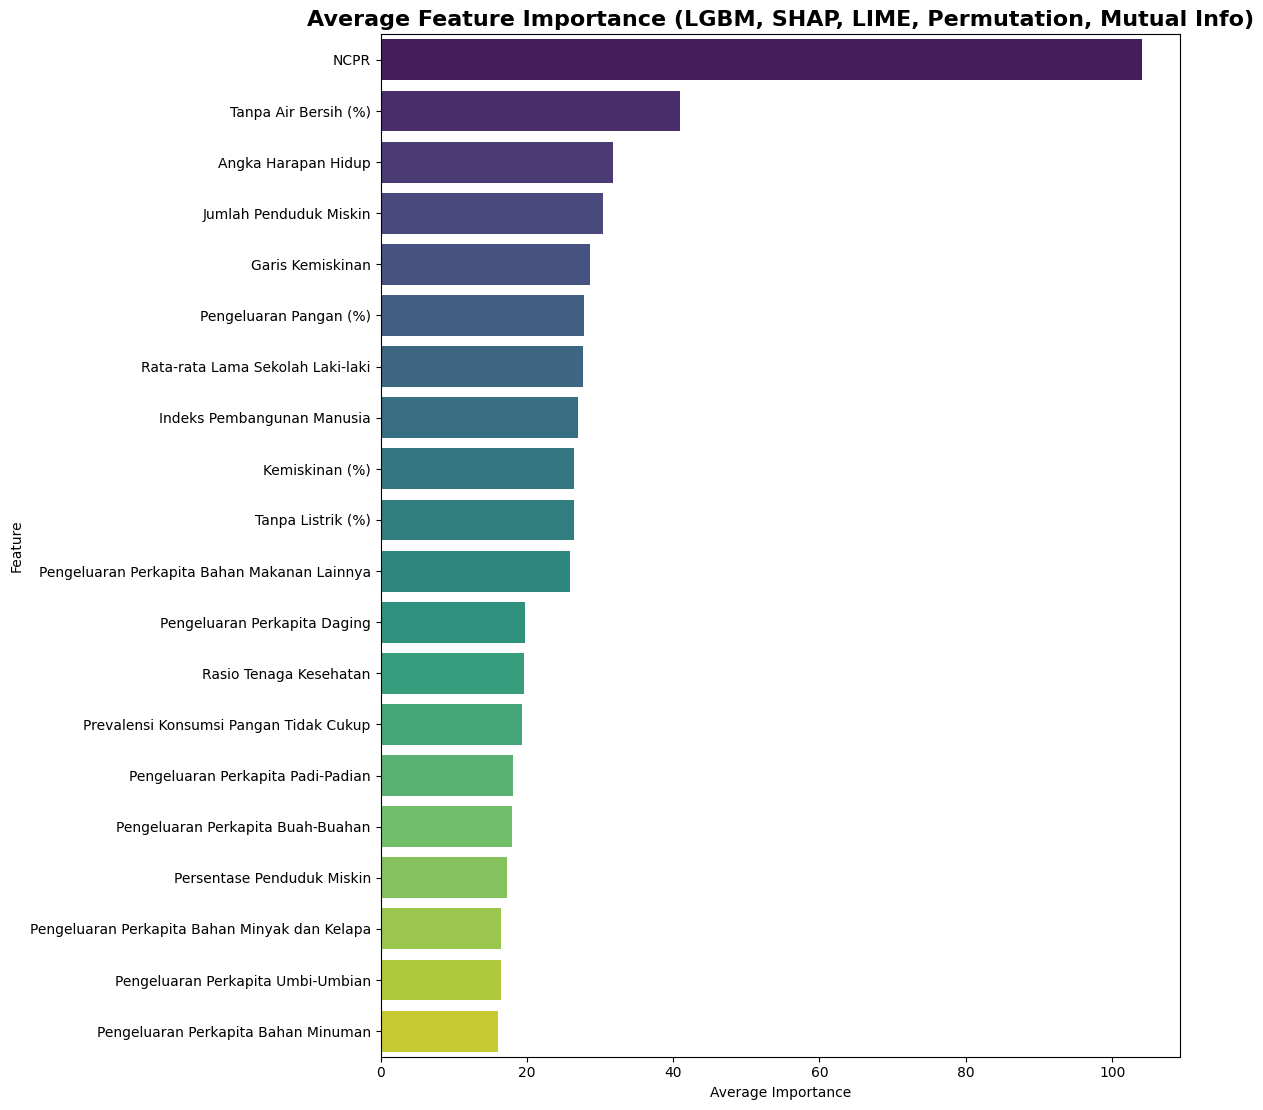

In [93]:
# Feature Importance Model Terbaik
# Load model
model = joblib.load('../model/best_lgb_grid_adasyn.joblib')

# Asumsi X_train_adasyn dan y_train_adasyn sudah tersedia (data asli training)
# Standarisasi fitur untuk LIME
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_train_adasyn), columns=X_train_adasyn.columns)

# === 1. LightGBM Built-in Feature Importance ===
lgb_importance = pd.DataFrame({
    'Feature': model.feature_name_,
    'LGBM': model.feature_importances_
})
lgb_importance['Feature'] = lgb_importance['Feature'].str.replace('_', ' ')

# === 2. SHAP Feature Importance ===
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_adasyn)
shap_mean = np.abs(shap_values).mean(axis=0)
shap_importance = pd.DataFrame({
    'Feature': X_train_adasyn.columns,
    'SHAP': shap_mean
})
shap_importance['Feature'] = shap_importance['Feature'].str.replace('_', ' ')

# === 3. LIME Feature Importance ===
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_scaled.values,
    feature_names=X_scaled.columns.tolist(),
    mode='classification',
    discretize_continuous=False
)

lime_scores = []
for i in range(50):  # sampling 50 data
    exp = lime_explainer.explain_instance(
        X_scaled.values[i],
        lambda x: model.predict_proba(scaler.inverse_transform(x)),
        num_features=X_scaled.shape[1]
    )
    temp = dict(exp.as_list())
    lime_scores.append([temp.get(f, 0) for f in X_scaled.columns])

lime_importance = pd.DataFrame({
    'Feature': X_scaled.columns,
    'LIME': np.abs(np.array(lime_scores)).mean(axis=0)
})
lime_importance['Feature'] = lime_importance['Feature'].str.replace('_', ' ')

# === 4. Permutation Importance ===
perm_result = permutation_importance(
    model,
    X_train_adasyn,
    y_train_adasyn,
    scoring='accuracy',
    n_repeats=30,
    random_state=42
)
perm_importance = pd.DataFrame({
    'Feature': X_train_adasyn.columns,
    'Permutation': perm_result.importances_mean
})
perm_importance['Feature'] = perm_importance['Feature'].str.replace('_', ' ')

# === 5. Mutual Information ===
mi_scores = mutual_info_classif(X_train_adasyn, y_train_adasyn, random_state=42)
mi_importance = pd.DataFrame({
    'Feature': X_train_adasyn.columns,
    'Mutual_Info': mi_scores
})
mi_importance['Feature'] = mi_importance['Feature'].str.replace('_', ' ')

# === Gabungkan semua feature importance ===
importance_df = lgb_importance.merge(shap_importance, on='Feature', how='outer')
importance_df = importance_df.merge(lime_importance, on='Feature', how='outer')
importance_df = importance_df.merge(perm_importance, on='Feature', how='outer')
importance_df = importance_df.merge(mi_importance, on='Feature', how='outer')
importance_df.fillna(0, inplace=True)

# Hitung rata-rata importance dan kontribusi
importance_df['Average_Importance'] = importance_df[['LGBM', 'SHAP', 'LIME', 'Permutation', 'Mutual_Info']].mean(axis=1)
importance_df['Contribution (%)'] = 100 * importance_df['Average_Importance'] / importance_df['Average_Importance'].sum()

# Urutkan berdasarkan rata-rata importance
importance_df = importance_df.sort_values(by='Average_Importance', ascending=False).reset_index(drop=True)

# Tampilkan semua fitur
pd.set_option('display.max_rows', None)
print("\n[Gabungan dan Rata-rata Feature Importance]")
display(importance_df)

# Visualisasi (Top 20 fitur agar tidak terlalu panjang)
plt.figure(figsize=(12, max(6, 0.4 * len(importance_df))))
sns.barplot(y='Feature', x='Average_Importance', data=importance_df.head(20), palette='viridis')
plt.title('Average Feature Importance (LGBM, SHAP, LIME, Permutation, Mutual Info)', fontsize=16, fontweight='bold')
plt.xlabel('Average Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [99]:
# Prediksi 2024
# Pisahkan fitur dan target
X_2024 = df_2024.drop(columns=['Target', 'Kabupaten/Kota', 'Tahun', 'Kelompok IKP'])
KabupatenKota_2024 = df_2024['Kabupaten/Kota']
y_2024 = df_2024['Target']

y_pred_best_model_2024 = best_lgb_grid_adasyn.predict(X_2024)
eval_best_model_2024 = evaluate_model(y_2024, y_pred_best_model_2024, model_name="Prediksi 2024")


🔍 Evaluasi: Prediksi 2024
Confusion Matrix:
 [[443   9]
 [  2  60]]


Accuracy         : 0.9786
Balanced Accuracy: 0.9739
Precision (Pos=1): 0.9955 | Weighted: 0.9803 | Macro: 0.9325
Recall    (Pos=1): 0.9801 | Weighted: 0.9786 | Macro: 0.9739
F1-Score  (Pos=1): 0.9877 | Weighted: 0.9791 | Macro: 0.9519


In [100]:
# Buat DataFrame hasil prediksi 2024
df_prediksi_2024 = pd.DataFrame({
    "Kabupaten/Kota": KabupatenKota_2024,
    "Prediksi": y_pred_best_model_2024
})